In [1]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid

import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
import utils.ssvep_analysis as sa

In [24]:
def read_data(file_path):
    df = pd.read_csv(file_path, skiprows=10, header=None)
    with open(file_path, 'r') as file:
        content = file.read()

    match = re.search(r'Frequency:\s*(\d+(\.\d+)?)', content)
    stimulus_frequency = float(match.group(1)) if match else None
    match = re.search(r'Tile Size:\s*(\d+(\.\d+)?)', content)
    tile_size = float(match.group(1)) if match else None
    match = re.search(r'Subject:\s*(.+)', content)
    subject = match.group(1) if match else None

    eeg_data = df.to_numpy()[:, 1:9].astype(float)
    marker = df.to_numpy()[:, -1].flatten()
    return eeg_data, marker, stimulus_frequency, tile_size, subject

def preprocess_data(eeg_data, highpass_cutoff, lowpass_cutoff, notch_bandwidth):
    preprocessed_data = sa.apply_ransac_detrending(eeg_data)
    preprocessed_data = sa.filter_extreme_values(preprocessed_data)
    if highpass_cutoff > 0:
        preprocessed_data = sa.apply_highpass_filter(preprocessed_data, cutoff=highpass_cutoff)
    if lowpass_cutoff > 0:
        preprocessed_data = sa.apply_lowpass_filter(preprocessed_data, cutoff=lowpass_cutoff)
    if notch_bandwidth > 0:
        preprocessed_data = sa.apply_notch_filter(preprocessed_data, bandwidth=notch_bandwidth)
    return preprocessed_data

def compute_r_value(signal, n_components, n_harmonics, stimulus_frequency):
    cca, target = sa.compute_cca(signal, n_components=n_components, n_harmonics=n_harmonics, stimulus_frequency=stimulus_frequency)
    x, y = cca.transform(signal, target)
    return np.corrcoef(x.flatten(), y.flatten())[0, 1]

def compute_cca_snr(eeg_data, marker, marker_value, n_components, n_harmonics, stimulus_frequency):
    signal = eeg_data[marker == marker_value,:]
    noise = eeg_data[marker == 'grey',:]
    return compute_r_value(signal, n_components, n_harmonics, stimulus_frequency) / compute_r_value(noise, n_components, n_harmonics, stimulus_frequency)

def process_file(file_path, highpass_cutoff=1, lowpass_cutoff=100, notch_bandwidth=1, n_components=1, n_harmonics=2):
    eeg_data, marker, stimulus_frequency, tile_size, subject = read_data(file_path)
    preprocessed_data = preprocess_data(eeg_data, highpass_cutoff, lowpass_cutoff, notch_bandwidth)
    cca_snr = compute_cca_snr(preprocessed_data, marker, 'black-and-white', n_components, n_harmonics, stimulus_frequency)
    return cca_snr, stimulus_frequency, tile_size, subject

def process_directory(directory_path, highpass_cutoff=1, lowpass_cutoff=100, notch_bandwidth=1, n_components=1, n_harmonics=2):
    cca_snr_list = []
    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)
        cca_snr, stimulus_frequency, tile_size, subject = process_file(file_path, highpass_cutoff, lowpass_cutoff, notch_bandwidth, n_components, n_harmonics)
        cca_snr_list.append({
            'subject': subject,
            'stimulus_frequency': stimulus_frequency, 
            'tile_size': tile_size, 
            'highpass_cutoff': highpass_cutoff, 
            'lowpass_cutoff': lowpass_cutoff, 
            'notch_bandwidth': notch_bandwidth, 
            'n_components': n_components, 
            'n_harmonics': n_harmonics, 
            'cca_snr': cca_snr, 
        })
    return pd.DataFrame(cca_snr_list)

def complete_search(search_space, directory_list):
    param_grid = ParameterGrid(search_space)
    valid_combinations = [params for params in param_grid if params['n_components'] <= 2 * params['n_harmonics']]

    df_list = []
    for combination in tqdm(valid_combinations):
        for directory in directory_list:
            df_list.append(process_directory(directory, **combination))

    df = pd.concat(df_list)
    df.to_csv('../data/params.csv', index=False)
    return df

search_space = {
    'highpass_cutoff': [0, 0.1, 0.5, 1],
    'lowpass_cutoff': [0, 35, 50, 100],
    'notch_bandwidth': [0, 1, 3, 6],
    'n_components': [1],
    'n_harmonics': [2],
}
directory_list = ['../data/2023-11-13/', '../data/2023-11-18/', '../data/2023-11-20/', '../data/2023-11-30/', '../data/2023-12-03/', '../data/2023-12-07/', '../data/2023-12-28/']
# df = complete_search(search_space, directory_list)
df = pd.read_csv('../data/params.csv')

In [3]:
correlations = df[['stimulus_frequency', 'tile_size', 'highpass_cutoff', 'lowpass_cutoff', 'notch_bandwidth', 'cca_snr']].corr()['cca_snr']
correlations.drop('cca_snr', inplace=True)
correlations.sort_values(ascending=False, inplace=True, key=lambda x: np.abs(x))
correlations

highpass_cutoff      -0.128108
stimulus_frequency    0.092261
notch_bandwidth       0.011750
tile_size            -0.008066
lowpass_cutoff       -0.002885
Name: cca_snr, dtype: float64

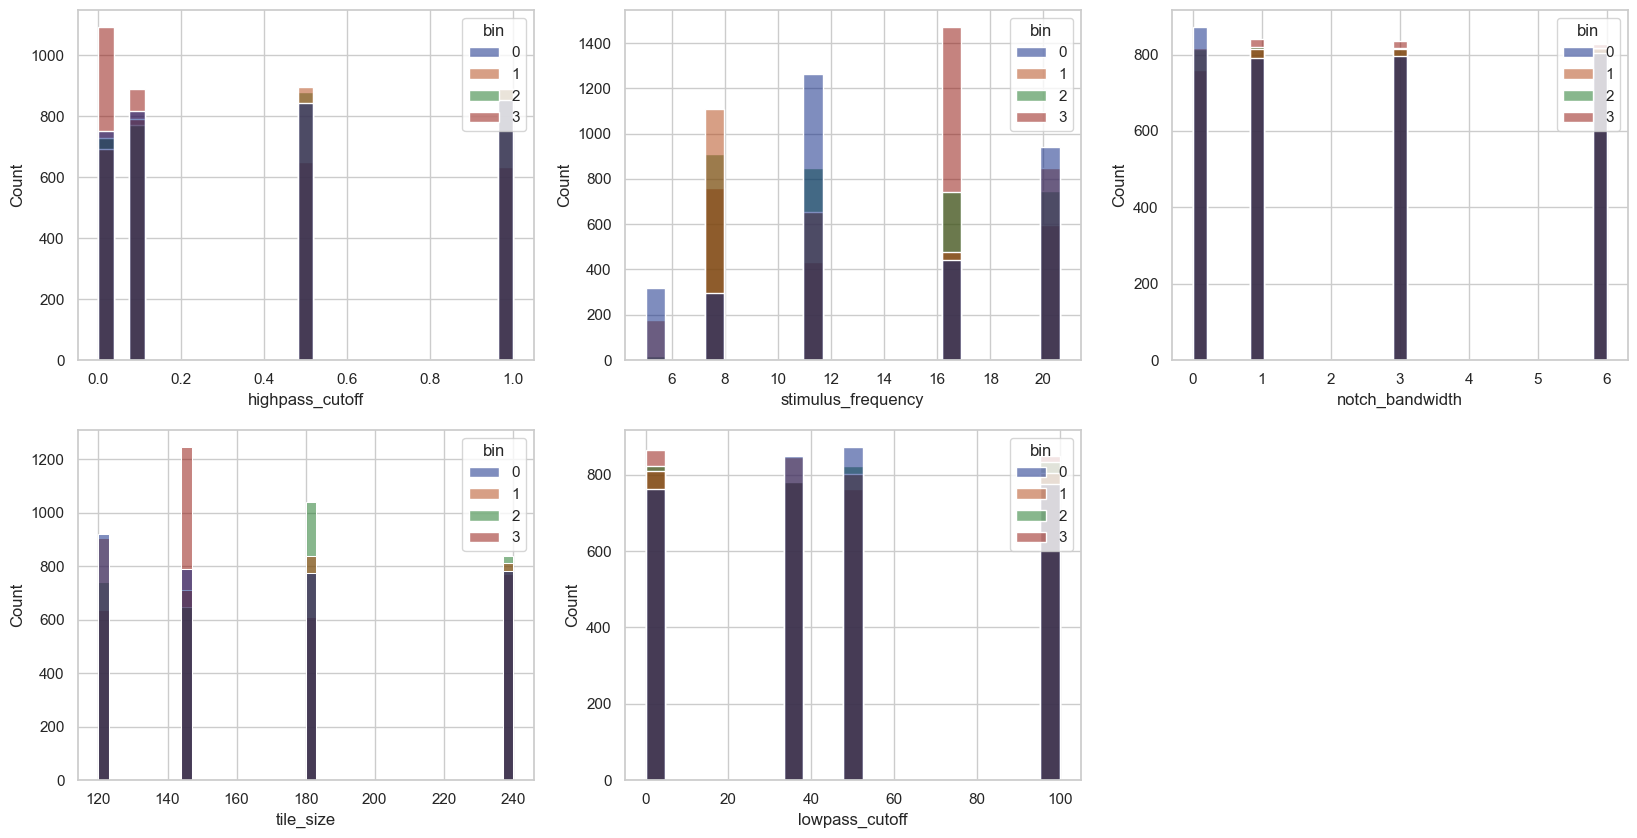

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

def bin_df(df, column, n_bins=4):
    bins = df[column].quantile(np.linspace(0, 1, n_bins + 1))
    df['bin'] = pd.cut(df[column], bins=bins, labels=range(n_bins))
    return df

def compute_percentage_ratio(df, column):
    value_count_df = pd.DataFrame(df[column].value_counts())

    bin_value_count_df = pd.DataFrame(df.groupby('bin')[column].value_counts())
    bin_count_df = pd.DataFrame(bin_value_count_df.groupby('bin').sum()['count'])
    bin_count_df.rename(columns={'count': 'count_bin_total'}, inplace=True)

    count_df = bin_value_count_df.join(value_count_df, on=column, how='left', lsuffix='_bin', rsuffix='_total')
    count_df = count_df.join(bin_count_df, on='bin', how='left')

    count_df['percentage_total'] = count_df['count_total'] / count_df.groupby(column).max()['count_total'].sum()
    count_df['percentage_bin'] = count_df['count_bin'] / count_df['count_bin_total']

    count_df['percentage_ratio'] = count_df['percentage_bin'] / count_df['percentage_total']

    return count_df

df = bin_df(df, 'cca_snr', n_bins=4)

ncols = 3
nrows = len(correlations.index) // ncols + 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))
for i, column in enumerate(correlations.index):
    sns.histplot(df, x=column, hue='bin', ax=ax[i  // ncols, i % ncols])

# clear unused axis
for i in range(len(correlations.index), ncols * nrows):
    ax[i  // ncols, i % ncols].axis('off')
plt.show()

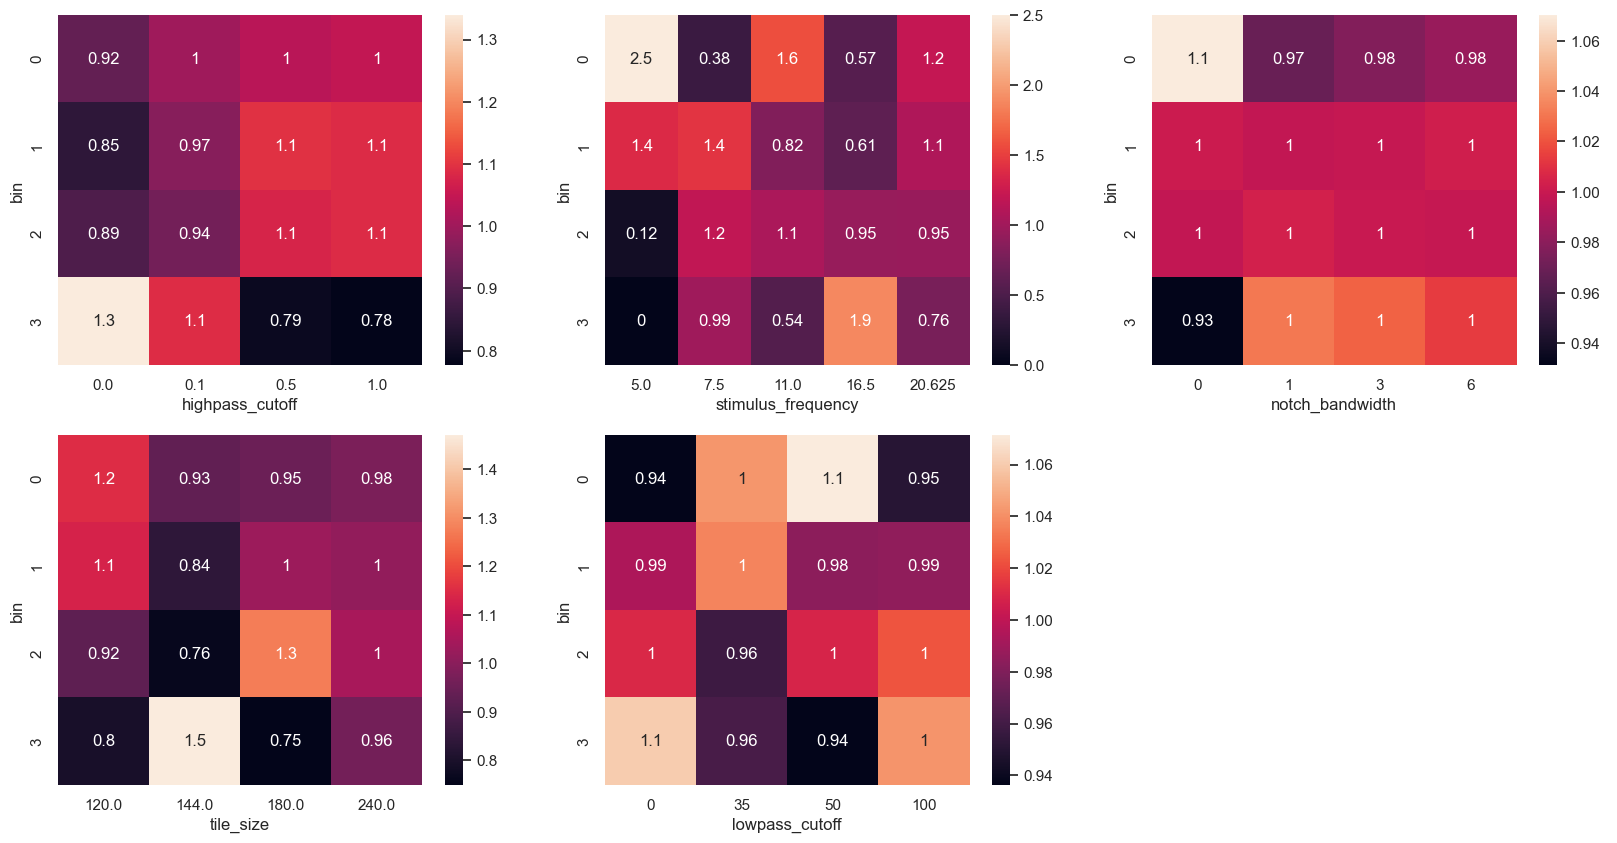

In [5]:
ncols = 3
nrows = len(correlations.index) // ncols + 1
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))
for i, column in enumerate(correlations.index):
    count_df = compute_percentage_ratio(df, column)
    matrix = count_df['percentage_ratio'].unstack(fill_value=0)
    sns.heatmap(matrix, annot=True, ax=ax[i  // ncols, i % ncols])

# clear unused axis
for i in range(len(correlations.index), ncols * nrows):
    ax[i  // ncols, i % ncols].axis('off')
plt.show()

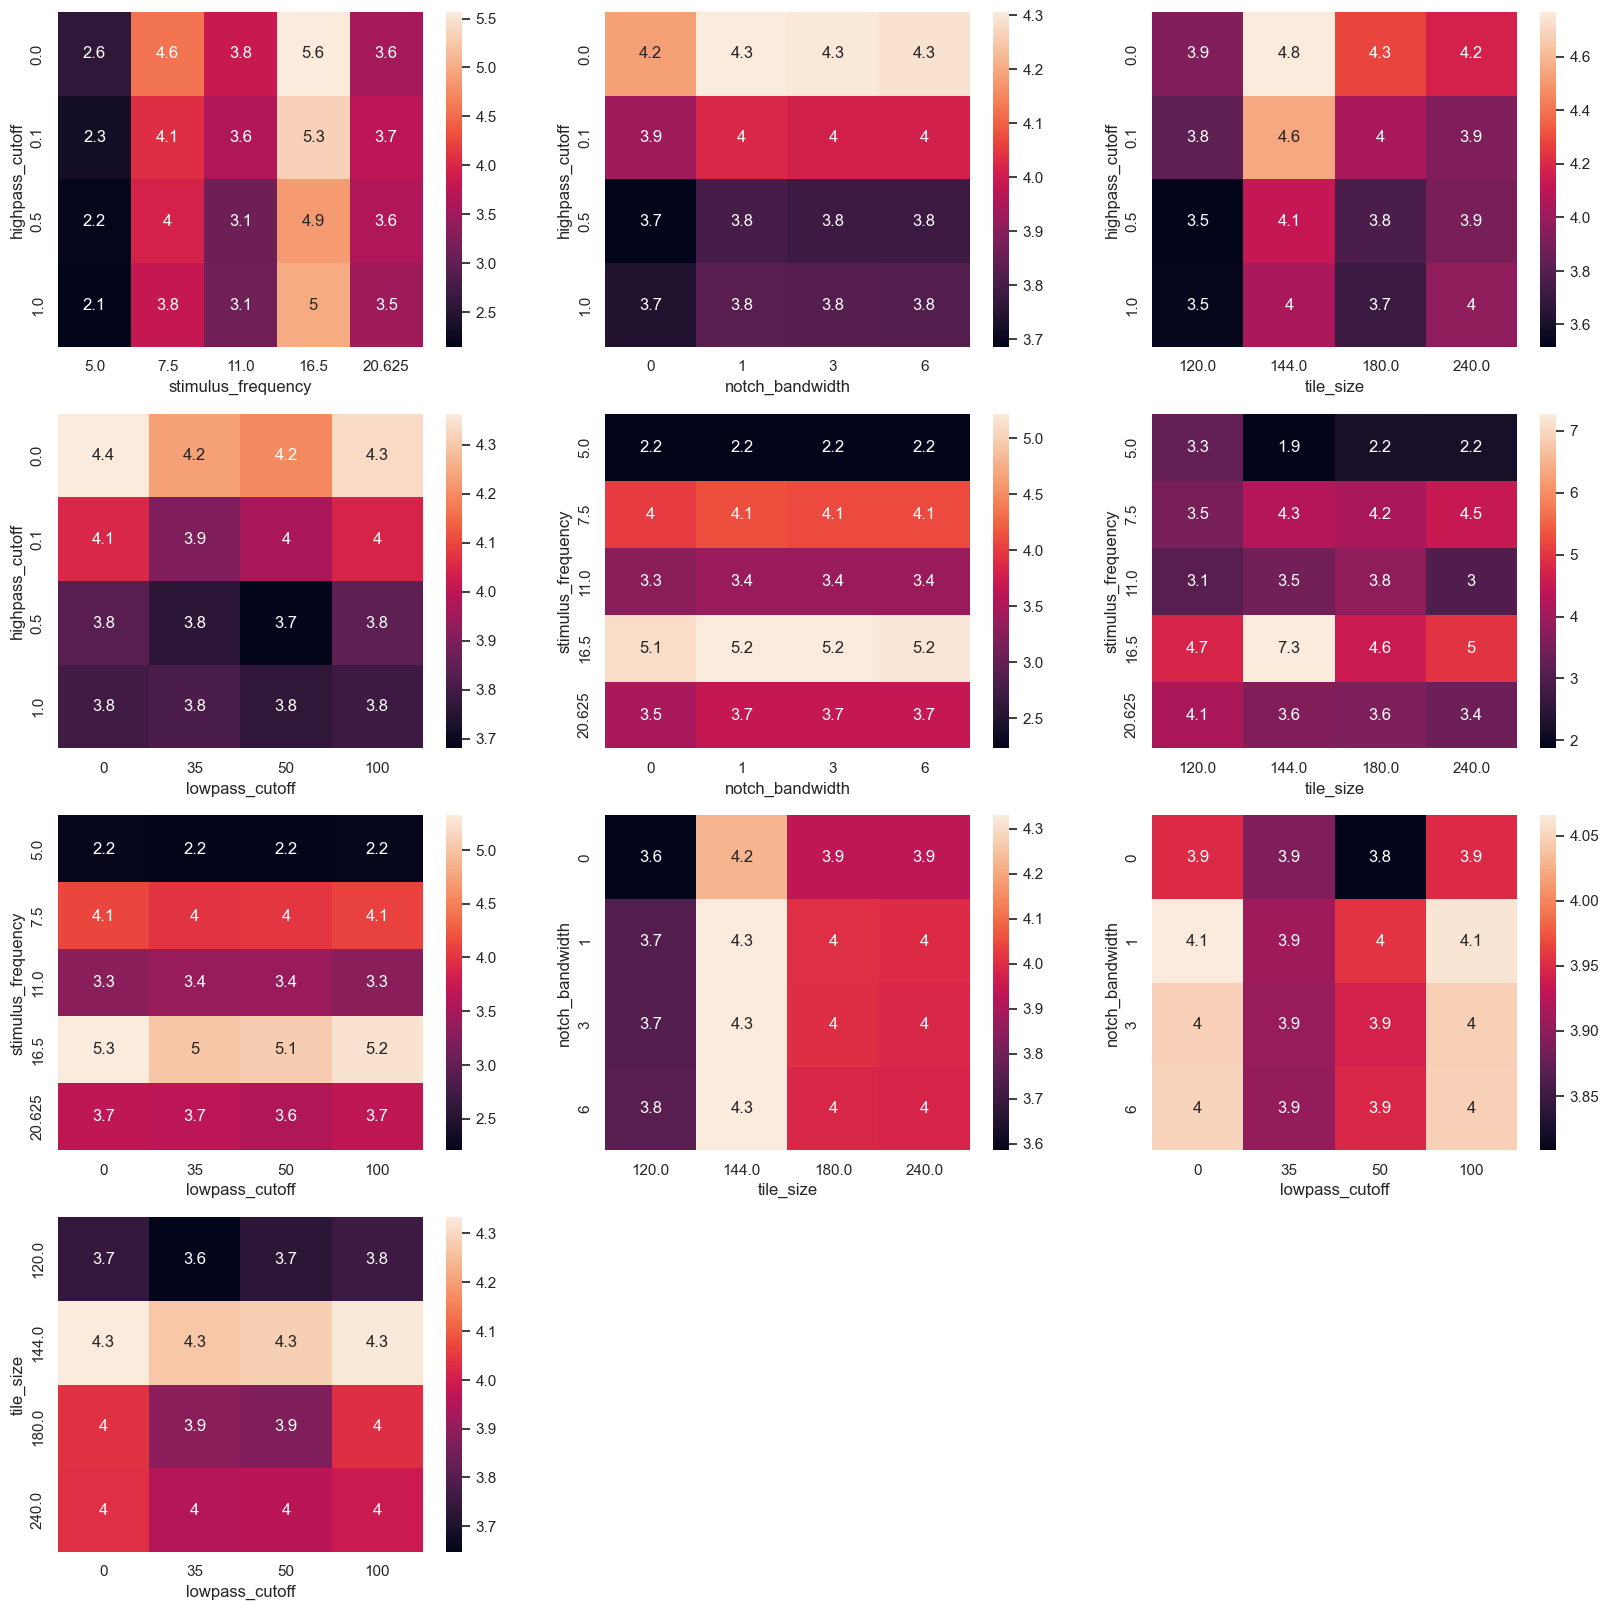

In [6]:
from itertools import combinations

combs = list(combinations(correlations.index, 2))
ncols = 3
nrows = len(combs) // ncols + 1

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
for i, (column1, column2) in enumerate(combs):
    tmp_df = pd.DataFrame(df[[column1, column2, 'cca_snr']].groupby([column1, column2]).median('cca_snr')).reset_index()
    matrix = tmp_df.pivot(index=column1, columns=column2, values='cca_snr')
    sns.heatmap(matrix, annot=True, ax=ax[i  // ncols, i % ncols])

# clear unused axis
for i in range(len(combs), ncols * nrows):
    ax[i  // ncols, i % ncols].axis('off')
plt.show()

In [7]:
medians_df = pd.DataFrame(df.drop('subject', axis=1).groupby(['stimulus_frequency', 'tile_size', 'highpass_cutoff', 'lowpass_cutoff', 'notch_bandwidth']).median('cca_snr')['cca_snr']).reset_index()
medians_df.iloc[medians_df.idxmax()['cca_snr']]

stimulus_frequency     16.500000
tile_size             144.000000
highpass_cutoff         0.000000
lowpass_cutoff          0.000000
notch_bandwidth         1.000000
cca_snr                 8.343268
Name: 833, dtype: float64

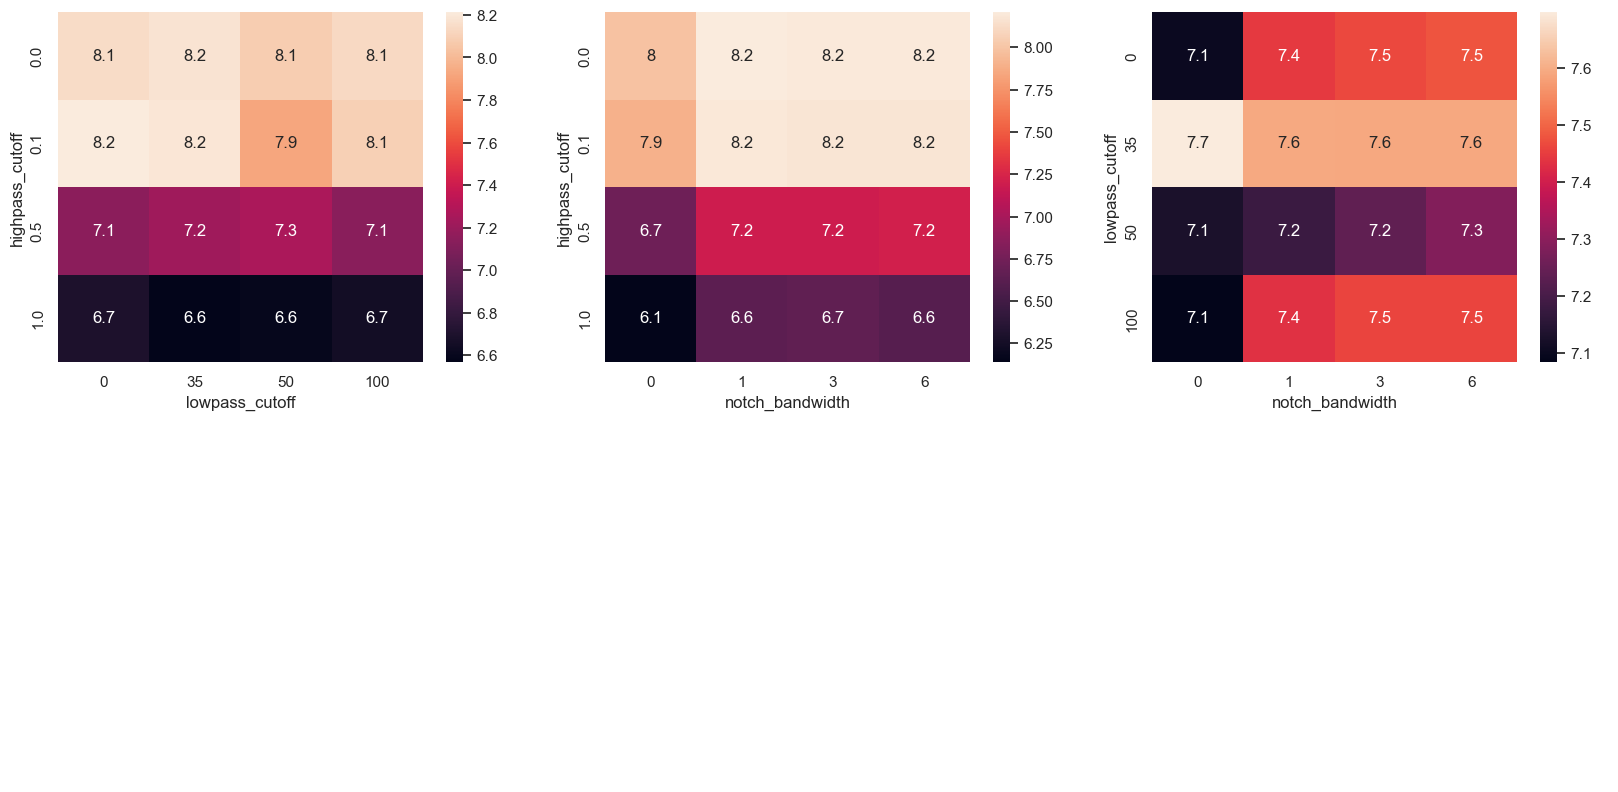

In [8]:
combs = list(combinations(['highpass_cutoff', 'lowpass_cutoff', 'notch_bandwidth'], 2))
ncols = 3
nrows = len(combs) // ncols + 1

df = df.query('stimulus_frequency == 16.5 and tile_size == 144')

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))
for i, (column1, column2) in enumerate(combs):
    tmp_df = pd.DataFrame(df[[column1, column2, 'cca_snr']].groupby([column1, column2]).median('cca_snr')).reset_index()
    matrix = tmp_df.pivot(index=column1, columns=column2, values='cca_snr')
    sns.heatmap(matrix, annot=True, ax=ax[i  // ncols, i % ncols])

# clear unused axis
for i in range(len(combs), ncols * nrows):
    ax[i  // ncols, i % ncols].axis('off')
plt.show()